***线性回归从零开始实现***   
不使用pytorch框架，只使用一些简单的tensor   
从底层了解每个模块具体怎么实现的   
从零开始实现整个方法，包括数据流水线，模型，损失函数，小批量随机梯度下降优化器

!pip install d2l

In [10]:
#为了能在jupyter中直接显示图
%matplotlib inline  
import random #随机梯度下降和随机初始化权重
import torch
from d2l import torch as d2l

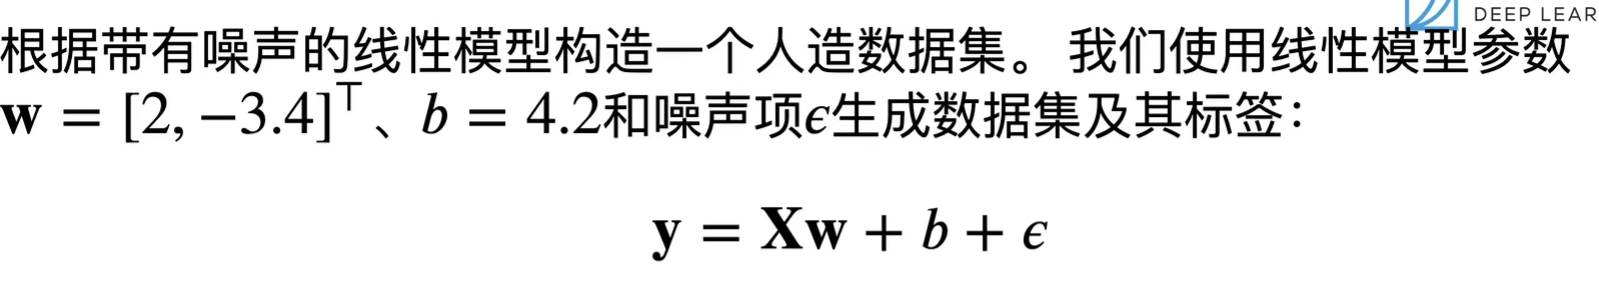

In [11]:
#生成数据的函数，w,b,num_examples分别代表权重，偏置，样本数量
#自己创建数据集的好处是w和b都是确定的
def synthetic_data(w,b,num_examples):
    x=torch.normal(0,1,(num_examples,len(w)))#先生成x,均值为0，方差为1的随机数，数据长度和一样
    y=torch.matmul(x,w)+b #torch.matmul()乘法，构造y
    y+=torch.normal(0,0.01,y.shape) #添加噪声，形状和y的长度一样
    return x,y.reshape(-1,1) #-1是指未指定行数，x和y作为一个列向量返回

true_w=torch.tensor([2,-3.4])
true_b=4.2
features,labels=synthetic_data(true_w,true_b,1000)

In [12]:
#features就是x,和w形状相同，每一行都包含一个二维数据的样本，labels就是y,每一行都包含一个一维标签值（一个标量）
features[0],labels[0]

(tensor([ 0.1735, -0.3851]), tensor([5.8529]))

In [13]:
d2l.set_figsize()
#d读取features的第一列。
d2l.plt.scatter(features[:,1]),labels,1);
#pytorch的一些版本中需要将他从计算图中detach出来，才能转化numpy
#.detach().numpy加入这个就会报错 

SyntaxError: unmatched ')' (1549673857.py, line 3)

In [14]:
#定义一个data_iter函数，该函数接受特征批量大小，特征矩阵和标签向量作为输入，生成大小为batch_sized的小批量
def data_iter(batch_size,features,labels):
    #求得样本数量
    num_examples=len(features)
    #对样本生成下标，生成一个列表
    indices=list(range(num_examples))
    #这些样本随机读取，打乱下标，没有特定顺序
    random.shuffle(indices)
    #从0-num_examples 每次跳batch_size
    for i in range(0,num_examples,batch_size):
        #print(i) 0
        #print(num_examples) 1000
        batch_indices=torch.tensor(indices[i:min(i+batch_size,num_examples)]) #标号可能会超过num_examples,所以取min
        yield features[batch_indices],labels[batch_indices] #yield每次返回一个样本值，直到全部完成
    
batch_size=10
for x,y in data_iter(batch_size,features,labels):
        print(x,'\n',y)
        break #为了让程序只执行一次，结束循环

tensor([[ 1.4300, -0.0277],
        [ 0.4550,  1.2729],
        [-0.3710,  0.2089],
        [-2.4969, -0.4803],
        [-0.4814, -1.3973],
        [-1.0119, -0.0835],
        [ 0.2725,  0.2074],
        [ 0.7356,  1.1095],
        [-0.6111,  1.9661],
        [ 2.0963,  0.4287]]) 
 tensor([[ 7.1391],
        [ 0.7830],
        [ 2.7547],
        [ 0.8253],
        [ 7.9908],
        [ 2.4759],
        [ 4.0253],
        [ 1.8958],
        [-3.7193],
        [ 6.9551]])


In [15]:
#定义初始化模型参数
w=torch.normal(0,0.01,size=(2,1),requires_grad=True) #w的值满足一个正态分布 形状是（2，1） 每次w的值都是不一样的
b=torch.zeros(1,requires_grad=True) #b的值是0

In [16]:
#定义模型 线性回归模型
def linreg(x,w,b):
    return torch.matmul(x,w)+b

In [17]:
#定义损失函数 均方误差=1/2*(y-y_hat)^2 y_hat是预测值  这里没有做均值，直接加起来了
def squared_loss(y_hat,y):
    return (y_hat-y.reshape(y_hat.shape))**2/2  #y.reshape(y_hat.shape)：确保y和y_hat形状一样

In [18]:
#定义优化算法 SGD params给定所有的参数，一个list,包含了所有的w和b
#小批量随机梯度下降
def sgd(params,lr,batch_size):
    with torch.no_grad():   #更新参数的时候不需要计算梯度
        for param in params:  #可能是w也可能是b
            param-=lr*param.grad/batch_size  #梯度是存在.grad里面的，这个除以batch_size是算平均值，因为损失函数那没有计算
            param.grad.zero_() #下次计算梯度的时候不会跟上次相关


In [19]:
#训练过程
#指定一些超参数
lr=0.03
num_epochs=3
net=linreg
loss=squared_loss

#range()可以创建一个整数列表，一般用在for循环里面
#训练过程一般是两个循环，外面循环扫描整个数据
for epoch in range(num_epochs):
    for x,y in data_iter(batch_size,features,labels):
        l=loss(net(x,w,b),y) #x和y的小批量损失 l的形状（batch_size,1)
        l.sum().backward() #反向传播计算关于[w,b]的梯度
        sgd([w,b],lr,batch_size)  #使用参数的梯度更新参数
     
    with torch.no_grad():  #不需要计算梯度了
        train_l=loss(net(features,w,b),labels) #总样本和总标签
        print(f'epoch {epoch+1},loss {float(train_l.mean()):f}')
        

epoch 1,loss 0.043997
epoch 2,loss 0.000168
epoch 3,loss 0.000048


***线性回归的简洁实现***   
***使用深度学习框架pytorch来简洁的实现线性回归模型生成数据集***

In [20]:
import numpy as np
import torch
from d2l import torch as d2l
from torch.utils import data  #一些数据处理的模块

In [21]:
true_w=torch.tensor([2,-3.4])
true_b=4.2
features,labels=d2l.synthetic_data(true_w,true_b,1000)

In [22]:
#调用框架中现有的API来读取数据
#得到features和labels之后，传入到data_array
#构造一个pytorch数据迭代器
def load_array(data_arrays,batch_size,is_train=True):
    #data.TensorDatase对数据封装，里面是features和labels，把数据放到数据库中
    dataset=data.TensorDataset(*data_arrays)  
    #data.DataLoader用来加载数据 shuffle=is_train打乱顺序，随机读取数据
    return data.DataLoader(dataset,batch_size,shuffle=is_train)
    
batch_size=10
data_iter=load_array((features,labels),batch_size)

#把data_iter变成一个python的iter
next(iter(data_iter))

[tensor([[ 0.5632,  0.9625],
         [-0.8016,  0.2991],
         [ 1.3522, -1.9016],
         [ 0.4314,  0.1666],
         [ 0.6817,  0.7127],
         [ 0.0761, -0.2760],
         [ 0.8120, -0.4621],
         [-0.4444,  0.0119],
         [-1.4112, -0.0063],
         [-1.2583, -0.2250]]),
 tensor([[ 2.0706],
         [ 1.5635],
         [13.3636],
         [ 4.4890],
         [ 3.1494],
         [ 5.3036],
         [ 7.3915],
         [ 3.2870],
         [ 1.4072],
         [ 2.4390]])]

In [23]:
#使用框架的预定义好的层
#nn是神经网络的缩写，里面定义了大量的定义好的层 对于线性回归来说，就是线性层（全连接层）
from torch import nn

#需要指定输入维度2和输出维度1
#nn.Sequential容器，可以理解为一个list，一些曾按顺序一个个放在一起
net=nn.Sequential(nn.Linear(2,1))

In [24]:
#初始化模型参数
#net[0]访问layer weight访问权重，data访问权重的数据，用normal_（0，0.01）重载data
net[0].weight.data.normal_(0,0.01)
net[0].bias.data.fill_(0)

tensor([0.])

In [25]:
#计算均方误差使用的是MSELoss类，也被称为平方L2范数
loss=nn.MSELoss()

In [26]:
#实例化SGD实例
#SGD至少传入两个参数，一个是所有的参数，一个是学习率
trainer=torch.optim.SGD(net.parameters(),lr=0.3)

In [30]:
#训练过程与从零开始训练非常类似
num_epochs=3

for epoch in range(num_epochs):
    for x,y in data_iter:
        l=loss(net(x),y)  #这是因为net里面已经有w和b了，就不需要考虑了
        trainer.zero_grad()
        l.backward() #pytorch已经算了sum
        trainer.step() #更新权重
    
    l=loss(net(features),labels) #不需要梯度清零，因为只有前向传播，没有反向传播
    print(f'epoch {epoch+1},loss {l:f}') #这里是L

epoch 1,loss 0.000112
epoch 2,loss 0.000118
epoch 3,loss 0.000114


1.损失求平均：若是不除以n，把学习率除以n就行，不管样本多大，批量大小，梯度的值都是差不多的<br>
2.线性回归损失函数一般都是MSE<br>
3.batch size越小，噪音越大（跟真实值差的远），现在神经网络太复杂了，有点噪音，模型的泛化性会更好  
4.学习率和batch size对模型的收敛么有那么影响   
5.随机梯度中的随机是指随机采样  
6.更新参数时减去的梯度是batch size样本对应的参数梯度求和后再求平均，因为损失函数相当于是对每个样本求平均，然后求7.导相当于是对每个样本都求导，然后求和求平均  
8.更关注收敛到哪个地方，而不是收敛的快慢  
9.判断收敛：两个epoch之间，目标函数变化不大;验证集精度不再增加
10.w的值固定还是随机不重要  
11.网络输出nan，因为求导，除法之类的，除0    
12.不一定手动设置参数初始值，可以用设置好的